

**Context: **

The goal of the project is to calssify the images of pants into 12 different species.   This is important to sor the plants from weeds. By correcly classifying them we can help the Agricultural scientist from a lot of Manual labor. 

So the purpose of this projec to deliver a Deep learning method that could help the farmers to identify the seedlings of interest (12 diff. species). This would help to decrese manual labor and seperating the weeds from the species of interest. 

**Objective: **

Building a Convolutional Neural Network model to classify the plant species into the 12 categories in the dataset.



**Importing the necessary libraries**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the Libraries
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import PIL
from PIL import Image
import matplotlib.pyplot as plt


**Reading the dataset**

In [5]:
# Loading the path of the image
#image_path = '/content/drive/My Drive/Computer_vision/images.npy'

image = np.load('/content/drive/My Drive/Computer_vision/images.npy')
# Import an image
#image = Image.open(image_path)

labels = pd.read_csv('/content/drive/My Drive/Computer_vision/Labels.csv')
# Extracting pixel map:
#pixel_matrix = image.load()

**Overview of the dataset**

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [8]:
print(image.shape)

(4750, 128, 128, 3)


In [9]:
print(labels.shape)

(4750, 1)


There are 4750 RGB images with 3 channels.

In [ ]:
labels.dtypes

Label    object
dtype: object

All images are object type

In [ ]:
labels.isnull().sum()

Label    0
dtype: int64

In [ ]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

There are 12 classes of lablels (plant species). Each category though is NOT represented equally, the no.of plants are not too imbalanced. There are about 5 categories which are about 1/3 of the max. category.



In [ ]:
labels.columns

Index(['Label'], dtype='object')

In [ ]:
from keras.utils import to_categorical

https://drive.google.com/drive/folders/1fCk5DsmT2b2fyJbCyEndHYgjCOrHTRxA?usp=sharing

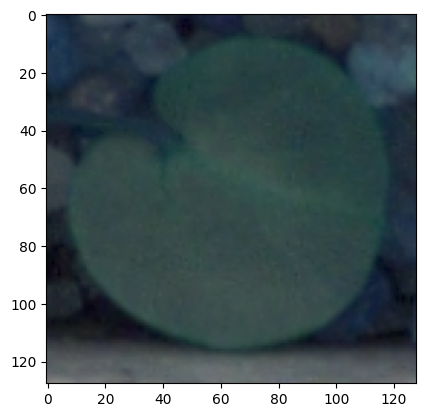

In [ ]:
image.shape

#print(image)

plt.imshow(image[300])
plt.show()

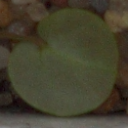

In [ ]:
cv2_imshow(image[300])

We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
Now we will convert these BGR images to RGB images so we could interpret them easily.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(image)):
  image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)

**Exploratory Data Analysis**

In [ ]:
def plot_images(images,label):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(label)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 6                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(16, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

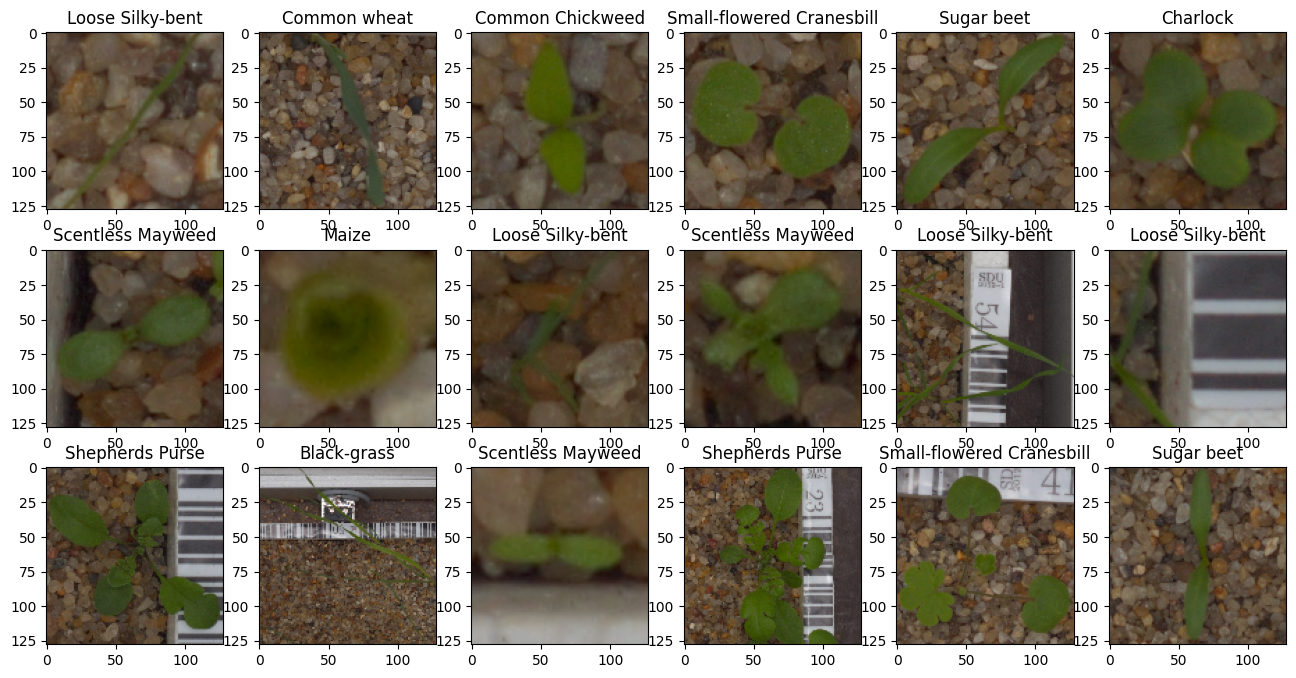

In [ ]:
plot_images(image,labels)

**Resizing images**

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(image)):
  images_decreased.append( cv2.resize(image[i], dimensions, interpolation=cv2.INTER_LINEAR))

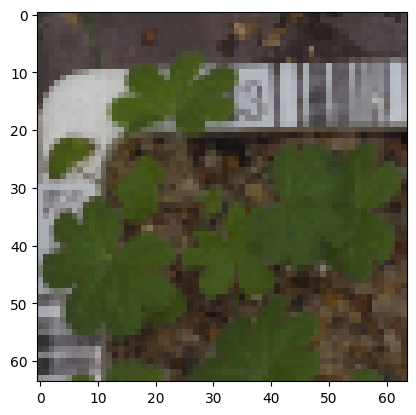

In [ ]:
plt.imshow(images_decreased[3])

**Visualizing images using Gaussian Blur**

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(image)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(image[i], ksize =(3,3),sigmaX =  0))

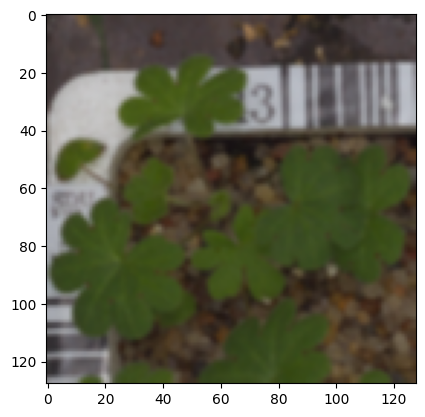

In [ ]:
plt.imshow(images_gb[3])

It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

Splitting the dataset
As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.
[ ]

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

**Splitting the dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


**Making the data compatiable**

Convert labels from names to one hot vectors and 
Normalizing the values

In [ ]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

**Data Normalization**
Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

**Normalisation**

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.
First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's set the seed for random number generators in  Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a CNN Model with the following 2 main parts - 
1.The Feature Extraction layers which are comprised of convolutional and pooling layers.
2. The Fully Connected classification layers for prediction.

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 40s - loss: 2.4534 - accuracy: 0.1258 - val_loss: 2.3999 - val_accuracy: 0.1495 - 40s/epoch - 330ms/step
Epoch 2/30
121/121 - 37s - loss: 2.3211 - accuracy: 0.1781 - val_loss: 2.1971 - val_accuracy: 0.2266 - 37s/epoch - 307ms/step
Epoch 3/30
121/121 - 36s - loss: 2.1247 - accuracy: 0.2423 - val_loss: 1.9983 - val_accuracy: 0.3294 - 36s/epoch - 299ms/step
Epoch 4/30
121/121 - 36s - loss: 2.0064 - accuracy: 0.2831 - val_loss: 1.8571 - val_accuracy: 0.3528 - 36s/epoch - 299ms/step
Epoch 5/30
121/121 - 34s - loss: 1.9794 - accuracy: 0.2849 - val_loss: 1.8021 - val_accuracy: 0.3528 - 34s/epoch - 277ms/step
Epoch 6/30
121/121 - 34s - loss: 1.9521 - accuracy: 0.2893 - val_loss: 1.7697 - val_accuracy: 0.3551 - 34s/epoch - 279ms/step
Epoch 7/30
121/121 - 36s - loss: 1.9287 - accuracy: 0.2771 - val_loss: 1.7389 - val_accuracy: 0.3621 - 36s/epoch - 294ms/step
Epoch 8/30
121/121 - 36s - loss: 1.8656 - accuracy: 0.2932 - val_loss: 1.6631 - val_accuracy: 0.3925 - 36s/epoch - 296

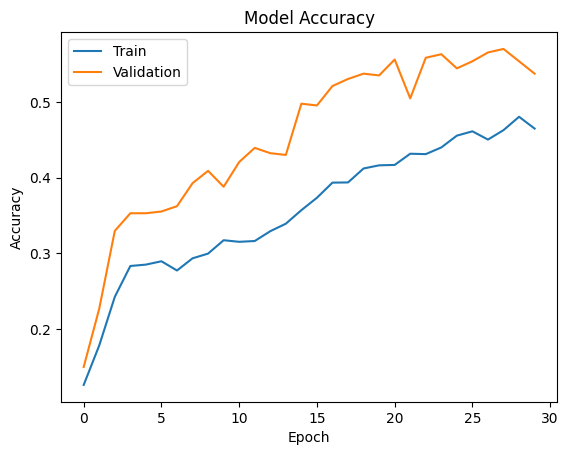

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Interesting, validation accuracy is  higher than the training accuracy, it suggests that the model is generalizing better to new data than to the training data. 

THe model seems to overfit the training data

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - loss: 1.1992 - accuracy: 0.6589 - 2s/epoch - 130ms/step


Since the accuracy of test to get a more accurate estimate of the model's generalization performance.

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 2s 140ms/step


In [ ]:
y_pred

array([[7.7967560e-10, 1.6569143e-08, 3.9472510e-09, ..., 2.0714018e-03,
        1.8543557e-06, 3.4927380e-05],
       [8.1565144e-10, 1.1652923e-03, 2.0329641e-04, ..., 1.0705155e-02,
        9.8780537e-01, 1.5139690e-05],
       [9.9756990e-06, 2.3269447e-04, 7.7975004e-05, ..., 1.5585183e-01,
        8.3731759e-01, 5.9001480e-04],
       ...,
       [1.5251793e-01, 9.7577987e-11, 2.4144914e-08, ..., 8.9242468e-12,
        1.0831549e-11, 2.5302748e-07],
       [1.5322420e-06, 8.9211093e-04, 5.1137246e-04, ..., 1.0252845e-01,
        6.1995356e-04, 7.7756336e-03],
       [3.5238564e-02, 8.3869956e-03, 1.1012267e-02, ..., 1.3649902e-01,
        7.9180941e-02, 9.9099599e-02]], dtype=float32)

**Plotting the Confusion Matrix**

1.The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
2.The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
3. We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

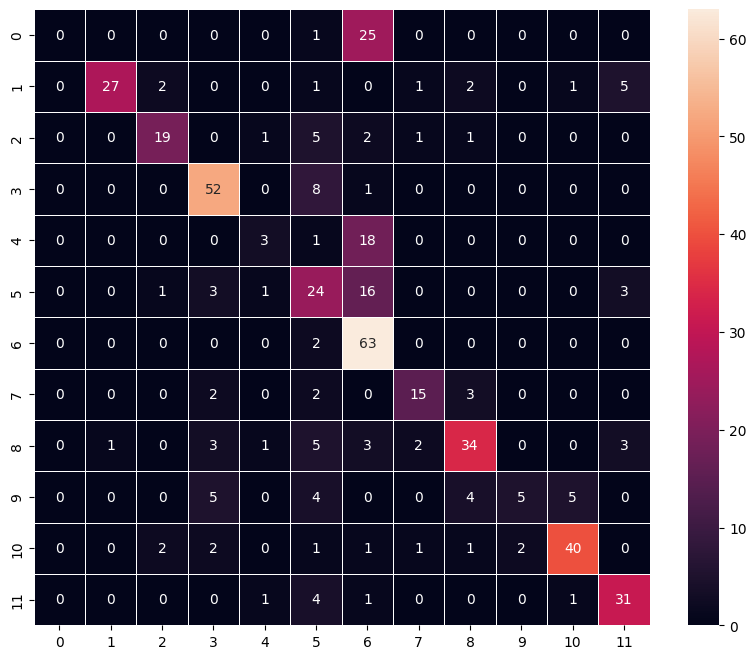

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observations:>

Good Predictions are for category 6 and 3.
We observe that some of the classes are not predicted correctly.
In comparison to the rest, we can see that classes 1,3, 6, 8 and 10 are well classified.
Classes 1 and 5 are not classified well.
We can also observe that classes 0,2,4, 7,9 and 11 are mostly misclassified.

Model-2

As we can see, our initial model appears to overfit.
Interestingly, it has more generalisability as the val. performance is better than training performance.

 Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance. 

**Data Augmentation**


In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is Data Augmentation. CNNs have the property of translational invariance, which means they can recognise an object even if its appearance shifts translationally in some way. 
Taking this attribute into account, we can augment the images using the techniques listed below - 
1. Horizontal Flip (should be set to True/False) 
2. Vertical Flip (should be set to True/False) 
3. Height Shift (should be between 0 and 1) 
4. Width Shift (should be between 0 and 1) 
5. Rotation (should be between 0 and 180) 
6. Shear (should be between 0 and 1) 
7. Zoom (should be between 0 and 1) etc. 


P.S: data augmentation should not be used in the validation/test data set.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )


Though there are many augumentation techniques, We used a very simple augumentation where we rotated the image by about 20 degrees.

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 58s 957ms/step - loss: 1.3646 - accuracy: 0.5321 - val_loss: 1.7661 - val_accuracy: 0.5935
Epoch 2/25
60/60 [==============================] - 39s 655ms/step - loss: 1.2873 - accuracy: 0.5530 - val_loss: 1.5273 - val_accuracy: 0.5724
Epoch 3/25
60/60 [==============================] - 42s 700ms/step - loss: 1.2535 - accuracy: 0.5612 - val_loss: 1.3588 - val_accuracy: 0.5374
Epoch 4/25
60/60 [==============================] - 42s 697ms/step - loss: 1.1784 - accuracy: 0.5786 - val_loss: 1.2952 - val_accuracy: 0.5981
Epoch 5/25
60/60 [==============================] - 44s 731ms/step - loss: 1.1529 - accuracy: 0.5887 - val_loss: 1.2791 - val_accuracy: 0.5467
Epoch 6/25
60/60 [==============================] - 41s 678ms/step - loss: 1.0917 - accuracy: 0.6109 - val_loss: 1.2100 - val_accuracy: 0.5748
Epoch 7/25
60/60 [==============================] - 39s 649ms/step - loss: 1.0717 - accuracy: 0.6196 - val_loss: 1.2114 - val_accuracy: 0.6075

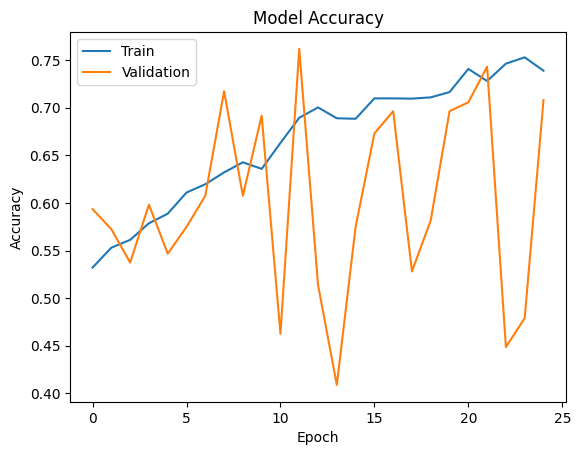

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

looks overfitting

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

Accuracy is better , but is a super overfit

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:
The confusion matrix appears to be improving as well, however there is still some confusion with the classes of plant species.
The 4th, 5th, 7 an 9 classes are misclassified.  Class 6 and class 3 are have less miscalssifications.
We can observe that this model has performed btter than our previous model.
But due to overfitting, want to explore other models

**Transfer Learning using VGG16**

Let's try again, but this time, we will be using the idea of Transfer Learning. We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

For training VGG16, we will directly use the convolutional and pooling layers 
and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                65568     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,780,988
Trainable params: 66,300
Non-

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [ ]:

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    validation_data=(X_val_normalized,y_val_encoded),
                    epochs=30,callbacks=[es, mc],use_multiprocessing=True)
                  

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 2.1297 - accuracy: 0.2727
Epoch 1: val_accuracy improved from -inf to 0.32710, saving model to best_model.h5
61/61 [==============================] - 196s 3s/step - loss: 2.1297 - accuracy: 0.2727 - val_loss: 2.0014 - val_accuracy: 0.3271
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 1.9505 - accuracy: 0.3197
Epoch 2: val_accuracy improved from 0.32710 to 0.35514, saving model to best_model.h5
61/61 [==============================] - 198s 3s/step - loss: 1.9505 - accuracy: 0.3197 - val_loss: 1.8550 - val_accuracy: 0.3551
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 1.8361 - accuracy: 0.3442
Epoch 3: val_accuracy improved from 0.35514 to 0.36916, saving model to best_model.h5
61/61 [==============================] - 198s 3s/step - loss: 1.8361 - accuracy: 0.3442 - val_loss: 1.7731 - val_accuracy: 0.3692
Epoch 4/30
61/61 [==============================] - ETA: 0s - loss: 1.738

We have better performance than the base model with 60% accuracy on Traning and 55% on validation. While base model had 55% and 53 repectively.


P.S: Here we used the input shape of the data set whihc is 124, 124, 3
But VGG16 takes input image of sizws 224X224.

We could have resized the input image  shape to the 124 of vgg16
or added Padding.
Lets test this one first and see.

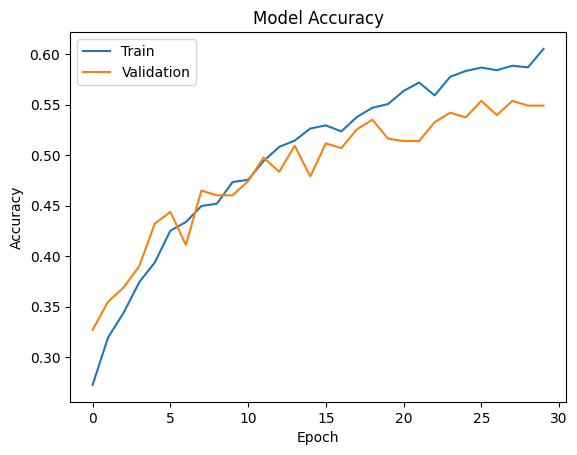

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

A reasonable  nice fit !. 

In [79]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 39s - loss: 1.1839 - accuracy: 0.6189 - 39s/epoch - 3s/step


Test data has 62% accuracy.

In [80]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 27s 2s/step


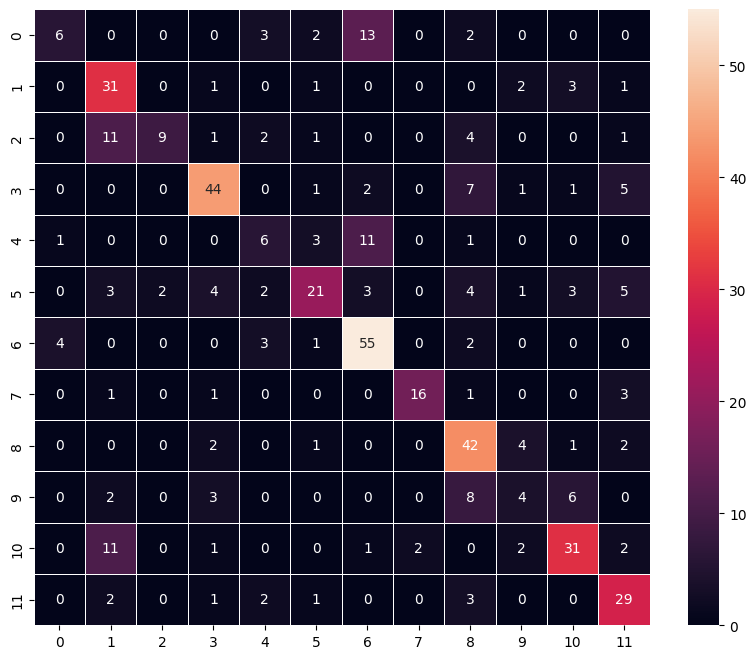

In [81]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Still there are misclassifications. 

FOr class 0, 2, 4, 9 are still mis-calssified.

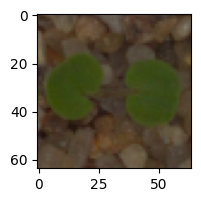

1/1 [==============================] - 0s 69ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


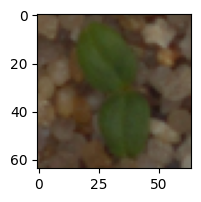

1/1 [==============================] - 0s 90ms/step
Predicted Label ['Scentless Mayweed']
True Label Cleavers


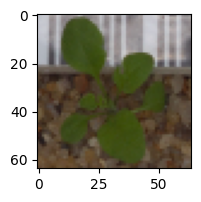

1/1 [==============================] - 0s 126ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Shepherds Purse


In [82]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report((normal_y_test), y_test_pred_classes_ln))

In [88]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['46%','73%','60%'],'Validation Accuracy':['53%','84%','54%'],'Test Accuracy':['55%','72%','62%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,46%,53%,55%
1,CNN Model with Data Augmentation,73%,84%,72%
2,Transfer Learning Model,60%,54%,62%


Summary:

1. In summary we have tested three models a. BAse Model. b. Simple data Aumentation with 20 degree image roation c. Transfer leraning. Of the three we found data augumentation helped with the classification, with a great improvement in the both validation and test accuracy.

We can however, explore other autmentation statagies, 

2. The models have been trained on the decreased images (64 X 64) instead of the orginal images of 128 X 128. Perhaps that could yield better classifications.

3. Perhaps we can also change the drop out rate and Batch normalisations. 